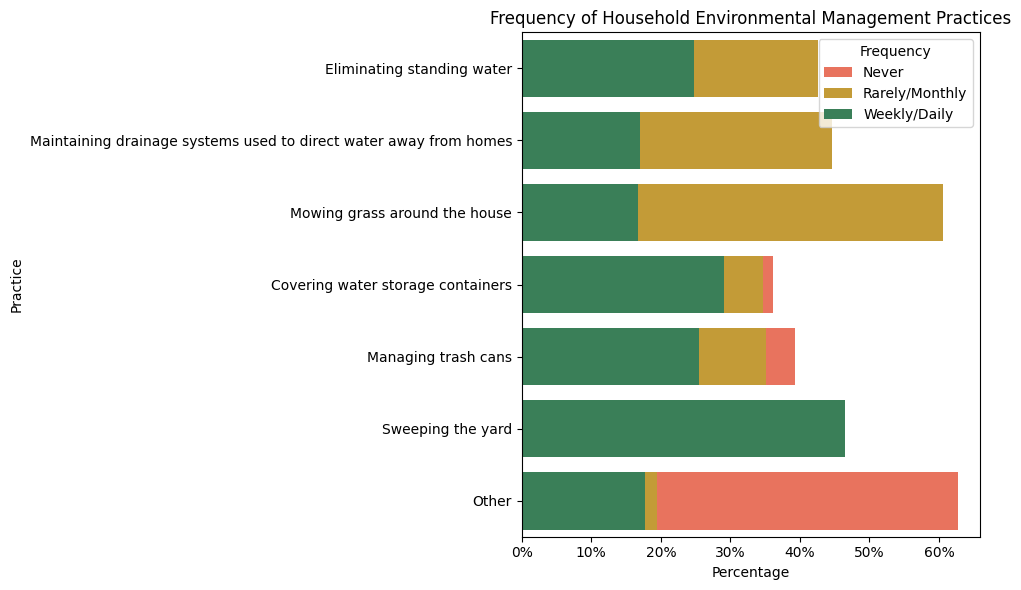

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#load the data
file_path = r'/content/Data of Malaria (THESIS) 17 april.xlsx'
sheet_name = 'Form responses 1'

#read the data
data = pd.read_excel(file_path, sheet_name=sheet_name)

# List of practice columns
practices = [
    'Eliminating standing water',
    'Maintaining drainage systems used to direct water away from homes',
    'Mowing grass around the house',
    'Covering water storage containers',
    'Managing trash cans',
    'Sweeping the yard',
    'Other'
]

#rename columns
renamed_columns = {
    'Frequency of other household environmental measures not included in the survey': 'Other'
}

# Apply renaming
data = data.rename(columns=renamed_columns)
practices = [renamed_columns.get(col, col) for col in practices]

# Function to group frequencies
def group_frequency(x):
    if pd.isna(x):
        return 'No Response'
    x = x.strip().lower()
    if x in ['monthly', 'rarely']:
        return 'Rarely/Monthly'
    elif x in ['weekly', 'daily']:
        return 'Weekly/Daily'
    elif x == 'never':
        return 'Never'
    else:
        return 'Other'

# Apply the grouping to each practice
for practice in practices:
    data[practice + '_grouped'] = data[practice].apply(group_frequency)

# summarize the counts for each practice
summary = {}

for practice in practices:
    counts = data[practice + '_grouped'].value_counts(normalize=True)  # normalize=True gives percentages
    summary[practice] = counts

# Create a DataFrame from the summary with percentages
practice_summary = pd.DataFrame(summary).fillna(0).T  # Transpose to get practices as rows

# Convert the index to a column for plotting
practice_summary.reset_index(inplace=True)
practice_summary = practice_summary.melt(id_vars=['index'], var_name='Frequency', value_name='Percent')
practice_summary.columns = ['Practice', 'Frequency', 'Percent']

# Create a bar plot
plt.figure(figsize=(10, 6))
palette = {
    "Weekly/Daily": "seagreen",  # add colors for other categories
    "Rarely/Monthly": "goldenrod",
    "Never": "tomato",
    "Other": "grey",  # if you have 'Other' category, you can add this as well
    "No Response": "lightgray"  # Optional for 'No Response' values
}

plot = sns.barplot(x='Percent', y='Practice', hue='Frequency', data=practice_summary, dodge=False, palette=palette)

# Set title and labels
plot.set_title("Frequency of Household Environmental Management Practices")
plot.set_xlabel("Percentage")
plot.set_ylabel("Practice")

# Show percentage on x-axis
from matplotlib.ticker import FuncFormatter
plot.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

# Rotate labels and add legend
plt.xticks(rotation=0)
plt.legend(title='Frequency')

# Display the plot
plt.tight_layout()
plt.show()

# save the summary to an Excel sheet
summary_df = pd.DataFrame({practice: counts for practice, counts in summary.items()}).fillna(0)
summary_df.to_excel(r'C:\Users\chard\Documents\practice_summary.xlsx', index=True)






In [ ]:

from scipy.stats import chi2_contingency, fisher_exact

# List of practice columns
practices = [
    'Eliminating standing water',
    'Maintaining drainage systems used to direct water away from homes',
    'Mowing grass around the house',
    'Covering water storage containers',
    'Managing trash cans',
    'Sweeping the yard'
]

breeding_sites = [
    'Observed breeding sites in the past year',
]

# Functions
def group_practice(x):
    if pd.isna(x):
        return 'Not Engaged'
    x = x.strip().lower()
    if x in ['weekly', 'daily']:
        return 'Engaged'
    else:
        return 'Not Engaged'

def standardize_binary(x):
    if pd.isna(x):
        return 'No'
    x = str(x).strip().lower()
    return 'Yes' if x == 'yes' else 'No'

def chi_square_or_fisher(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    if contingency_table.shape == (2, 2):
        _, p_value = fisher_exact(contingency_table)
    else:
        _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value

# Prepare data
for practice in practices:
    df[practice + '_grouped'] = df[practice].apply(group_practice)

for site in breeding_sites:
    df[site + '_bin'] = df[site].apply(standardize_binary)

df['Malaria_History'] = df['History of malaria in the past year in the household'].apply(standardize_binary)

# Analyze associations
results_practices_breeding = {}
results_practices_malaria = {}

for practice in practices:
    practice_col = practice + '_grouped'

    # Association with breeding sites
    breeding_col = 'Observed breeding sites in the past year_bin'
    p_val_breeding = chi_square_or_fisher(df, practice_col, breeding_col)
    results_practices_breeding[practice] = p_val_breeding

    # Association with malaria history
    malaria_col = 'Malaria_History'
    p_val_malaria = chi_square_or_fisher(df, practice_col, malaria_col)
    results_practices_malaria[practice] = p_val_malaria
# Sort and print results
print("\n--- Association between Practices and Mosquito Breeding Sites ---")
for practice, p_val in sorted(results_practices_breeding.items(), key=lambda x: x[1]):
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{practice}: p-value = {p_val:.4f} ({significance})")

print("\n--- Association between Practices and Malaria History ---")
for practice, p_val in sorted(results_practices_malaria.items(), key=lambda x: x[1]):
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{practice}: p-value = {p_val:.4f} ({significance})")


--- Association between Practices and Mosquito Breeding Sites ---
Maintaining drainage systems used to direct water away from homes: p-value = 0.1029 (Not Significant)
Managing trash cans: p-value = 0.1131 (Not Significant)
Sweeping the yard: p-value = 0.2816 (Not Significant)
Mowing grass around the house: p-value = 0.8395 (Not Significant)
Covering water storage containers: p-value = 0.8658 (Not Significant)
Eliminating standing water: p-value = 1.0000 (Not Significant)

--- Association between Practices and Malaria History ---
Sweeping the yard: p-value = 0.0067 (Significant)
Managing trash cans: p-value = 0.0352 (Significant)
Covering water storage containers: p-value = 0.2239 (Not Significant)
Mowing grass around the house: p-value = 0.4118 (Not Significant)
Eliminating standing water: p-value = 0.4819 (Not Significant)
Maintaining drainage systems used to direct water away from homes: p-value = 0.6249 (Not Significant)


In [ ]:
# Urban vs Rural comparison

# Standardize area of residence
df['Area_Residence'] = df['Area of residence'].apply(lambda x: str(x).strip().capitalize())

# Preventive measures to analyze
preventive_measures = [
    'Use of malaria preventive measures',
    'LLITNs',
    'Insecticide sprays',
    'Mosquito coils',
    'House modification e.g putting up wire nets on windows'
]

# Standardize preventive measures to Yes/No
def standardize_prevention(x):
    if pd.isna(x):
        return 'No'
    x = str(x).strip().lower()
    return 'Yes' if x == 'yes' else 'No'

for measure in preventive_measures:
    df[measure + '_bin'] = df[measure].apply(standardize_prevention)

# Function to run chi-square or fisher test between Urban/Rural for a variable
def compare_urban_rural(df, target_col):
    contingency_table = pd.crosstab(df['Area_Residence'], df[target_col])
    if contingency_table.shape == (2, 2):
        _, p_value = fisher_exact(contingency_table)
    else:
        _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value

# Variables to compare
compare_variables = ['Malaria_History'] + [m + '_bin' for m in preventive_measures] + [p + '_grouped' for p in practices]

# Run tests
urban_rural_results = {}

for var in compare_variables:
    p_val = compare_urban_rural(df, var)
    urban_rural_results[var] = p_val

# Sort and print results
print("\n--- Urban vs Rural Comparison ---")
for var, p_val in sorted(urban_rural_results.items(), key=lambda x: x[1]):
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{var}: p-value = {p_val:.4f} ({significance})")


--- Urban vs Rural Comparison ---
Malaria_History: p-value = 0.0005 (Significant)
Mowing grass around the house_grouped: p-value = 0.3701 (Not Significant)
Maintaining drainage systems used to direct water away from homes_grouped: p-value = 0.4736 (Not Significant)
Sweeping the yard_grouped: p-value = 0.4999 (Not Significant)
Managing trash cans_grouped: p-value = 0.5405 (Not Significant)
Use of malaria preventive measures_bin: p-value = 0.7508 (Not Significant)
Covering water storage containers_grouped: p-value = 0.8825 (Not Significant)
LLITNs_bin: p-value = 1.0000 (Not Significant)
Insecticide sprays_bin: p-value = 1.0000 (Not Significant)
Mosquito coils_bin: p-value = 1.0000 (Not Significant)
House modification e.g putting up wire nets on windows_bin: p-value = 1.0000 (Not Significant)
Eliminating standing water_grouped: p-value = 1.0000 (Not Significant)


In [ ]:

import statsmodels.api as sm
from statsmodels.formula.api import logit

# Step 1: Prepare the key variables

# Environmental engagement outcome: whether the household engaged
practices = [
    'Eliminating standing water',
    'Maintaining drainage systems used to direct water away from homes',
    'Mowing grass around the house',
    'Covering water storage containers',
    'Managing trash cans',
    'Sweeping the yard'
]

# Simplify practices into Engaged/Not Engaged
def engaged(x):
    if pd.isna(x):
        return 0
    return 1 if x.strip().lower() in ['weekly', 'daily'] else 0

# Apply to all practices
for practice in practices:
    df[practice + '_engaged'] = df[practice].apply(engaged)

# Create a total engagement score
df['Engagement_Score'] = df[[p + '_engaged' for p in practices]].sum(axis=1)

# Define "high engagement" as doing 3 or more practices weekly/daily
df['High_Engagement'] = df['Engagement_Score'].apply(lambda x: 1 if x >= 3 else 0)

#Step 2: Prepare predictors (household resources, maintenance, community engagement)

# Standardize binary predictors
def yes_no_binary(x):
    if pd.isna(x):
        return 0
    return 1 if str(x).strip().lower() == 'yes' else 0

# Predictors
df['Higher_Education'] = df['Level of education'].apply(lambda x: 1 if str(x).strip().lower() == 'higher education' else 0)
df['Employed'] = df['Occupation'].apply(lambda x: 1 if str(x).strip().lower() == 'employed' else 0)
df['Challenges_Faced'] = df['Presence of challenges in maintaining practices'].apply(yes_no_binary)
df['Community_Engagement'] = df['Community engagement in control of mosquito breeding sites'].apply(yes_no_binary)

# Step 3: Run Logistic Regression

# Define formula
formula = 'High_Engagement ~ Higher_Education + Employed + Challenges_Faced + Community_Engagement'

# Fit logistic regression
model = logit(formula=formula, data=df).fit()

# Show results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.618764
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        High_Engagement   No. Observations:                  282
Model:                          Logit   Df Residuals:                      277
Method:                           MLE   Df Model:                            4
Date:                Mon, 28 Apr 2025   Pseudo R-squ.:                0.007613
Time:                        19:26:10   Log-Likelihood:                -174.49
converged:                       True   LL-Null:                       -175.83
Covariance Type:            nonrobust   LLR p-value:                    0.6132
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7573      0.573     -1.321      0.187      -1.881       0.366

In [ ]:

#Step 1: Prepare engagement outcome

practices = [
    'Eliminating standing water',
    'Maintaining drainage systems used to direct water away from homes',
    'Mowing grass around the house',
    'Covering water storage containers',
    'Managing trash cans',
    'Sweeping the yard'
]

def engaged(x):
    if pd.isna(x):
        return 0
    return 1 if x.strip().lower() in ['weekly', 'daily'] else 0

for practice in practices:
    df[practice + '_engaged'] = df[practice].apply(engaged)

df['Engagement_Score'] = df[[p + '_engaged' for p in practices]].sum(axis=1)
df['High_Engagement'] = df['Engagement_Score'].apply(lambda x: 1 if x >= 3 else 0)

# Step 2: Prepare predictors

def yes_no_binary(x):
    if pd.isna(x):
        return 0
    return 1 if str(x).strip().lower() == 'yes' else 0

df['Higher_Education'] = df['Level of education'].apply(lambda x: 1 if str(x).strip().lower() == 'higher education' else 0)
df['Employed'] = df['Occupation'].apply(lambda x: 1 if str(x).strip().lower() == 'employed' else 0)
df['Challenges_Faced'] = df['Presence of challenges in maintaining practices'].apply(yes_no_binary)
df['Community_Engagement'] = df['Community engagement in control of mosquito breeding sites'].apply(yes_no_binary)

# New predictors
df['Malaria_History'] = df['History of malaria in the past year in the household'].apply(yes_no_binary)
df['Area_Residence'] = df['Area of residence'].apply(lambda x: 1 if str(x).strip().lower() == 'urban area' else 0)  # 1=Urban, 0=Rural
df['Malaria_Cases'] = pd.to_numeric(df['Cases of malaria in the past year'], errors='coerce').fillna(0)

#Step 3: Run Improved Logistic Regression

# Define formula including new variables
formula = ('High_Engagement ~ Higher_Education + Employed + Challenges_Faced + '
           'Community_Engagement + Malaria_History + Area_Residence + Malaria_Cases')

# Fit logistic regression
model = logit(formula=formula, data=df).fit()

# Show full results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.614035
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        High_Engagement   No. Observations:                  282
Model:                          Logit   Df Residuals:                      274
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Apr 2025   Pseudo R-squ.:                 0.01520
Time:                        19:43:10   Log-Likelihood:                -173.16
converged:                       True   LL-Null:                       -175.83
Covariance Type:            nonrobust   LLR p-value:                    0.6180
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.4803      0.664     -0.724      0.469      -1.781       0.820

In [ ]:


# Step 1: Prevalence of any breeding site observation, by Urban/Rural

# Standardize breeding site observation column
def yes_no(x):
    if pd.isna(x):
        return 'No'
    x = str(x).strip().lower()
    return 'Yes' if x in ['yes', 'observed', 'present'] else 'No'

df['Observed_Breeding_Site'] = df['Observed breeding sites in the past year'].apply(yes_no)

# Standardize area of residence
df['Area_Residence'] = df['Area of residence'].apply(lambda x: str(x).strip().capitalize())

# Group by Area_Residence and count
breeding_site_summary = pd.crosstab(df['Area_Residence'], df['Observed_Breeding_Site'], margins=True)

print("\n--- Observed Breeding Sites by Area ---")
print(breeding_site_summary)

# Step 2: Prevalence of specific breeding sites (which types were most common)

# List of specific sites
specific_sites = [
    'Stagnant water',
    'Uncovered water storage containers',
    'Swamps',
    'Bushes',
    'Drainage channels',
    'Thick grass',
    'Trash cans'
]

# Standardize yes/no for specific breeding sites
for site in specific_sites:
    df[site + '_bin'] = df[site].apply(yes_no)

# Count how many 'Yes' for each site
site_counts = {}
for site in specific_sites:
    count_yes = (df[site + '_bin'] == 'Yes').sum()
    site_counts[site] = count_yes

# Convert to DataFrame for easier viewing
site_counts_df = pd.DataFrame.from_dict(site_counts, orient='index', columns=['Count'])
site_counts_df = site_counts_df.sort_values(by='Count', ascending=False)

print("\n--- Most Common Breeding Sites ---")
print(site_counts_df)


--- Observed Breeding Sites by Area ---
Observed_Breeding_Site  No  Yes  All
Area_Residence                      
Rural area              13   62   75
Urban area              39  168  207
All                     52  230  282

--- Most Common Breeding Sites ---
                                    Count
Stagnant water                        152
Thick grass                           135
Drainage channels                     116
Bushes                                 97
Trash cans                             96
Uncovered water storage containers     93
Swamps                                 62


In [ ]:

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

#step 1:load the data
file_path = r'/content/Data of Malaria (THESIS) 17 april.xlsx'
sheet_name = 'Form responses 1'

#read the data
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Step 2: Prepare Dependent Variables
df = data.copy()

# Malaria incidence (1 = Yes, 0 = No)
df['malaria_incidence'] = df['History of malaria in the past year in the household'].map({'Yes': 1, 'No': 0})

# Mosquito breeding site presence: infer from bad environmental practices
bad_practices_cols = [
    'Removing stagnant water in open places like markets and hospitals',
    'Sweeping the yard',
    'Eliminating standing water',
    'Mowing grass around the house',
    'Maintaining drainage systems used to direct water away from homes',
    'Covering water storage containers',
    'Managing trash cans'
]

# Encode Yes=0 (good), No=1 (bad) for practices
for col in bad_practices_cols:
    df[col] = df[col].map({'Yes': 0, 'No': 1})

# Create new dependent variable
df['breeding_site_presence'] = (df[bad_practices_cols].sum(axis=1) > 2).astype(int)

# Step 3: Prepare Independent Variables
independent_vars = [
    'Level of education',
    'Area of residence',
    'Community engagement in control of mosquito breeding sites'
]

# Encode categorical variables
le = LabelEncoder()
for col in independent_vars:
    df[col] = le.fit_transform(df[col].astype(str))

# Step 4: Helper function to remove multicollinearity
def reduce_multicollinearity(X, threshold=5.0):
    while True:
        vif = pd.DataFrame()
        vif["feature"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        max_vif = vif["VIF"].max()
        if max_vif > threshold:
            feature_to_remove = vif.loc[vif["VIF"] == max_vif, "feature"].values[0]
            print(f"Removing {feature_to_remove} due to high VIF ({max_vif})")
            X = X.drop(columns=[feature_to_remove])
        else:
            break
    return X

# Step 5: Run Logistic Regression Models
outcomes = ['malaria_incidence', 'breeding_site_presence']

for outcome in outcomes:
    print(f"\n==== Logistic Regression for {outcome} ====")

    y = df[outcome]
    X = df[independent_vars]
    X = reduce_multicollinearity(X)
    X_const = sm.add_constant(X)

    # Fit logistic model
    model = sm.Logit(y, X_const).fit()

    # Print full model summary
    print(model.summary())

    # Print Odds Ratios and 95% CI
    params = model.params
    conf = model.conf_int()
    conf['OR'] = np.exp(params)
    conf.columns = ['2.5%', '97.5%', 'OR']
    odds_ratios = np.exp(conf[['2.5%', '97.5%', 'OR']])

    print("\nOdds Ratios and 95% Confidence Intervals:")
    print(odds_ratios)

    # Classification report
    y_pred_prob = model.predict(X_const)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    print("\nClassification Report:")
    print(classification_report(y, y_pred))


==== Logistic Regression for malaria_incidence ====
Optimization terminated successfully.
         Current function value: 0.627002
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      malaria_incidence   No. Observations:                  282
Model:                          Logit   Df Residuals:                      278
Method:                           MLE   Df Model:                            3
Date:                Fri, 02 May 2025   Pseudo R-squ.:                 0.05541
Time:                        11:59:56   Log-Likelihood:                -176.81
converged:                       True   LL-Null:                       -187.19
Covariance Type:            nonrobust   LLR p-value:                 0.0001189
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [ ]:

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare Dependent Variables
df = data.copy()

# Malaria incidence (1 = Yes, 0 = No)
df['malaria_incidence'] = df['History of malaria in the past year in the household'].map({'Yes': 1, 'No': 0})

# Mosquito breeding site presence: infer from bad environmental practices
bad_practices_cols = [
    'Eliminating standing water',
    'Sweeping the yard',
    'Engaged in household environmental measures',
    'Mowing grass around the house',
    'Maintaining drainage systems used to direct water away from homes',
    'Covering water storage containers',
    'Managing trash cans'
]

# Encode Yes=0 (good), No=1 (bad) for practices
for col in bad_practices_cols:
    df[col] = df[col].map({'Yes': 0, 'No': 1})

# Create new dependent variable
df['breeding_site_presence'] = (df[bad_practices_cols].sum(axis=1) > 2).astype(int)

# Step 2: Prepare Independent Variables
independent_vars = [
    'Level of education',
    'Area of residence',
    'Engaged in household environmental measures',
    'Community engagement in control of mosquito breeding sites',
    'Occupation'
]

# Encode categorical variables
le = LabelEncoder()
for col in independent_vars:
    df[col] = le.fit_transform(df[col].astype(str))

# Step 3: Helper function to remove multicollinearity
def reduce_multicollinearity(X, threshold=5.0):
    while True:
        vif = pd.DataFrame()
        vif["feature"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        max_vif = vif["VIF"].max()
        if max_vif > threshold:
            feature_to_remove = vif.loc[vif["VIF"] == max_vif, "feature"].values[0]
            print(f"Removing {feature_to_remove} due to high VIF ({max_vif})")
            X = X.drop(columns=[feature_to_remove])
        else:
            break
    return X

# Step 4: Run Logistic Regression Models
outcomes = ['malaria_incidence', 'breeding_site_presence']

for outcome in outcomes:
    print(f"\n==== Logistic Regression for {outcome} ====")

    y = df[outcome]
    X = df[independent_vars]
    X = reduce_multicollinearity(X)
    X_const = sm.add_constant(X)

    # Fit logistic model
    model = sm.Logit(y, X_const).fit()

    # Print full model summary
    print(model.summary())

    # Print Odds Ratios and 95% CI
    params = model.params
    conf = model.conf_int()
    conf['OR'] = np.exp(params)
    conf.columns = ['2.5%', '97.5%', 'OR']
    odds_ratios = np.exp(conf[['2.5%', '97.5%', 'OR']])

    print("\nOdds Ratios and 95% Confidence Intervals:")
    print(odds_ratios)

    # Classification report
    y_pred_prob = model.predict(X_const)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    print("\nClassification Report:")
    print(classification_report(y, y_pred))


==== Logistic Regression for malaria_incidence ====
Optimization terminated successfully.
         Current function value: 0.618885
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      malaria_incidence   No. Observations:                  282
Model:                          Logit   Df Residuals:                      276
Method:                           MLE   Df Model:                            5
Date:                Sun, 04 May 2025   Pseudo R-squ.:                 0.06764
Time:                        16:16:58   Log-Likelihood:                -174.53
converged:                       True   LL-Null:                       -187.19
Covariance Type:            nonrobust   LLR p-value:                 0.0001206
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [ ]:

# Step 1: Calculate general proportion of people facing any challenge
challenge_col = 'Presence of challenges in maintaining practices'
challenge_type_col = 'Type of challenges faced'
area_col = 'Area of residence'

# Making sure relevant columns are properly loaded
df = data[[challenge_col, challenge_type_col, area_col]].copy()

# Overall proportion facing any challenges
total_responses = len(df)
people_with_challenges = df[df[challenge_col] == 'Yes']
proportion_with_challenges = len(people_with_challenges) / total_responses

print(f"Proportion of people facing any challenges: {proportion_with_challenges:.2%}")

# Step 2: Among those who face challenges, find breakdown
# (Checking if challenge type contains keywords)
financial_challenges = people_with_challenges[people_with_challenges[challenge_type_col].str.contains('financial', case=False, na=False)]
time_constraints = people_with_challenges[people_with_challenges[challenge_type_col].str.contains('time', case=False, na=False)]

prop_financial = len(financial_challenges) / len(people_with_challenges)
prop_time = len(time_constraints) / len(people_with_challenges)

print(f"Among people facing challenges:")
print(f"- Financial challenges: {prop_financial:.2%}")
print(f"- Time constraints: {prop_time:.2%}")

# Step 3: Differences between Urban and Rural Areas (correct labels)
print("\n--- Urban vs Rural Area Comparison ---")

for area in ['Urban area', 'Rural area']:
    area_df = df[df[area_col] == area]
    total_area = len(area_df)

    if total_area == 0:
        print(f"\nArea: {area} - No respondents, skipping...")
        continue

    challenges_area = area_df[area_df[challenge_col] == 'Yes']

    proportion_area_challenges = len(challenges_area) / total_area
    financial_area = challenges_area[challenges_area[challenge_type_col].str.contains('financial', case=False, na=False)]
    time_area = challenges_area[challenges_area[challenge_type_col].str.contains('time', case=False, na=False)]

    prop_financial_area = len(financial_area) / len(challenges_area) if len(challenges_area) > 0 else 0
    prop_time_area = len(time_area) / len(challenges_area) if len(challenges_area) > 0 else 0

    print(f"\nArea: {area}")
    print(f"- Proportion facing challenges: {proportion_area_challenges:.2%}")
    print(f"- Among them, Financial challenges: {prop_financial_area:.2%}")
    print(f"- Among them, Time constraints: {prop_time_area:.2%}")

Proportion of people facing any challenges: 50.35%
Among people facing challenges:
- Financial challenges: 61.27%
- Time constraints: 49.30%

--- Urban vs Rural Area Comparison ---

Area: Urban area
- Proportion facing challenges: 50.24%
- Among them, Financial challenges: 54.81%
- Among them, Time constraints: 52.88%

Area: Rural area
- Proportion facing challenges: 50.67%
- Among them, Financial challenges: 78.95%
- Among them, Time constraints: 39.47%


In [ ]:
#1 simple regre with breeding sites and env management
import pandas as pd
import statsmodels.api as sm

#load the data
file_path = r'/content/Data of Malaria (THESIS) 17 april.xlsx'
sheet_name = 'Form responses 1'

#read the data
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Step 2: Convert Yes/No to binary (1/0)
df['breeding_sites'] = df['Observed breeding sites in the past year'].map({'Yes': 1, 'No': 0})
df['environmental_engagement'] = df['Engaged in household environmental measures'].map({'Yes': 1, 'No': 0})

# Step 3: Add constant for intercept
X = sm.add_constant(df['environmental_engagement'])  # Predictor
y = df['breeding_sites']                             # Outcome

# Step 4: Run logistic regression
model = sm.Logit(y, X).fit()

# Step 5: Summary output
print(model.summary())

# Optional: get odds ratios
import numpy as np
odds_ratios = np.exp(model.params)
print("\nOdds Ratios:\n", odds_ratios)


Optimization terminated successfully.
         Current function value: 0.471913
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         breeding_sites   No. Observations:                  282
Model:                          Logit   Df Residuals:                      280
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 May 2025   Pseudo R-squ.:                 0.01273
Time:                        20:36:01   Log-Likelihood:                -133.08
converged:                       True   LL-Null:                       -134.79
Covariance Type:            nonrobust   LLR p-value:                   0.06399
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.5108      0.516      0.989      0.323      -0.501

  Participation Response  Number of Respondents  Percentage
0                    Yes                    113        56.5
1        No, but willing                     77        38.5
2     No and not willing                     10         5.0


<ipython-input-6-94459520c87f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


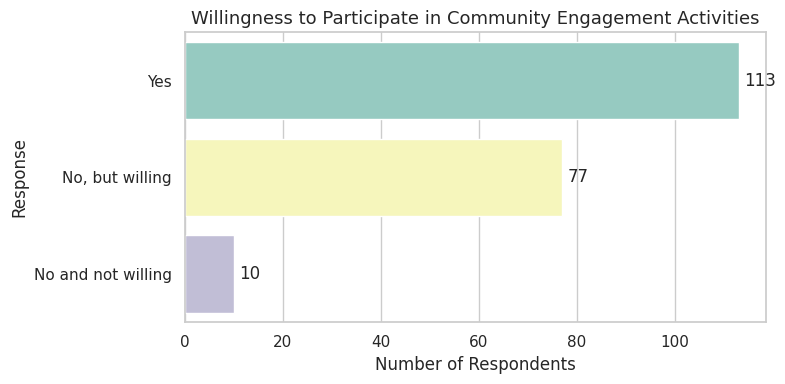

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Clean the column name just in case ---
data.columns = data.columns.str.strip()

# --- Define the column of interest ---
participation_col = 'participation in community activities'

# --- Clean and count responses ---
participation_counts = data[participation_col].value_counts(normalize=False).reindex(
    ['Yes', 'No, but willing', 'No and not willing']
)

# --- Plot ---
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

ax = sns.barplot(
    x=participation_counts.values,
    y=participation_counts.index,
    palette='Set3'
)

# --- Add count labels ---
for i, v in enumerate(participation_counts.values):
    plt.text(v + 1, i, str(v), va='center')

    # Count responses
participation_summary = data['participation in community activities'].value_counts().reset_index()
participation_summary.columns = ['Participation Response', 'Number of Respondents']

# Add percentages
participation_summary['Percentage'] = round(
    (participation_summary['Number of Respondents'] / participation_summary['Number of Respondents'].sum()) * 100, 1
)

# Display the summary
print(participation_summary)


# --- Labels and title ---
plt.title("Willingness to Participate in Community Engagement Activities", fontsize=13)
plt.xlabel("Number of Respondents")
plt.ylabel("Response")
plt.tight_layout()
plt.show()

Total number of malaria cases: 491
 - In Rural Areas: 201 (40.9%)
 - In Urban Areas: 290 (59.1%)

History of malaria responses:
 - Yes: 175 (62.1%)
 - No: 107 (37.9%)


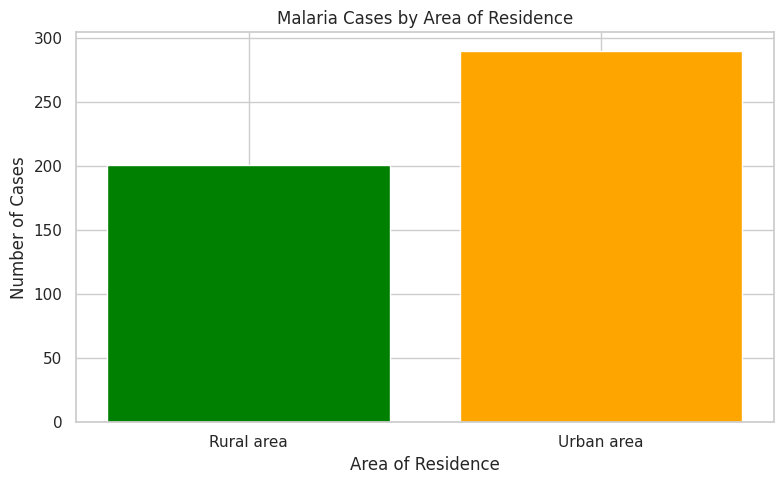

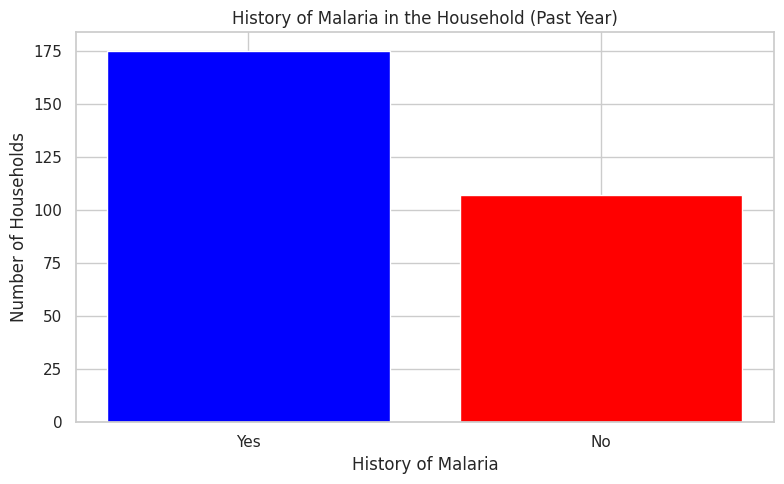

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#load the data
file_path = r'/content/Data of Malaria (THESIS) 17 april.xlsx'
sheet_name = 'Form responses 1'

#read the data
data = pd.read_excel(file_path, sheet_name=sheet_name)
# Total number of malaria cases
total_cases = data['Cases of malaria in the past year'].sum()

# Malaria cases by area type
cases_by_area = data.groupby('Area of residence')['Cases of malaria in the past year'].sum()
total_by_area = cases_by_area.to_dict()
total_cases_rural = total_by_area.get('Rural area', 0)
total_cases_urban = total_by_area.get('Urban area', 0)

# Percentages
percent_rural = (total_cases_rural / total_cases) * 100 if total_cases else 0
percent_urban = (total_cases_urban / total_cases) * 100 if total_cases else 0

# History of malaria
history_counts = data['History of malaria in the past year in the household'].value_counts()
yes_history = history_counts.get('Yes', 0)
no_history = history_counts.get('No', 0)
total_responses = yes_history + no_history
percent_yes = (yes_history / total_responses) * 100 if total_responses else 0
percent_no = (no_history / total_responses) * 100 if total_responses else 0

# Print summary
print("Total number of malaria cases:", total_cases)
print(f" - In Rural Areas: {total_cases_rural} ({percent_rural:.1f}%)")
print(f" - In Urban Areas: {total_cases_urban} ({percent_urban:.1f}%)")
print("\nHistory of malaria responses:")
print(f" - Yes: {yes_history} ({percent_yes:.1f}%)")
print(f" - No: {no_history} ({percent_no:.1f}%)")

# Plot: Malaria cases by area
plt.figure(figsize=(8, 5))
plt.bar(['Rural area', 'Urban area'], [total_cases_rural, total_cases_urban], color=['green', 'orange'])
plt.title('Malaria Cases by Area of Residence')
plt.ylabel('Number of Cases')
plt.xlabel('Area of Residence')
plt.tight_layout()
plt.show()

# Plot: History of malaria in household
plt.figure(figsize=(8, 5))
plt.bar(['Yes', 'No'], [yes_history, no_history], color=['blue', 'red'])
plt.title('History of Malaria in the Household (Past Year)')
plt.ylabel('Number of Households')
plt.xlabel('History of Malaria')
plt.tight_layout()
plt.show()